In [ ]:
# Check system install
import torch
print(torch.__version__)
print(torch.cuda.is_available())  # Should return True if GPU is detected

# Imports
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
import random
import torchvision.transforms as transforms
from tqdm import tqdm # Progress bar
from torch.utils.data import Dataset
from PIL import Image



2.6.0+cu126
True


100%|██████████| 84/84 [00:00<00:00, 10351.74it/s]


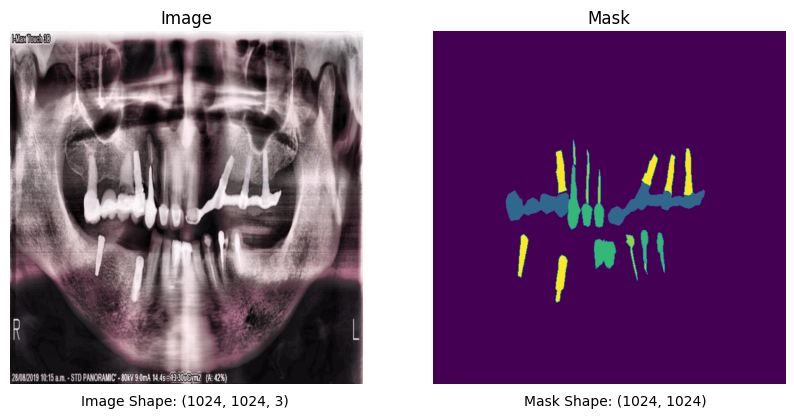

In [ ]:
# Holds information and gives access to a dataset spliit of images. Uses on-the-fly loading.
class ImageMaskDataset(Dataset):
    def __init__(self, dataset_path, split):
        """
        Args:
            dataset_path (str): Path to the dataset.
            split (str): Split of the dataset (e.g., 'train', 'test').
            transform (callable, optional): A function/transform to apply to the images.
        """
        self.dataset_path = dataset_path
        self.split = split
        self.transform = transforms.Compose([transforms.Resize((1024, 1024)), transforms.ToTensor()])
        
        # Get the dirs for images and masks
        self.split_dir = os.path.join(dataset_path, split)
        self.mask_dir = os.path.join(self.split_dir, "masks")
        
        # Get list of image-mask pairs
        self.image_mask_pairs = []

        # Skip if directory doesn't exist
        if not os.path.exists(self.split_dir) or not os.path.exists(self.mask_dir):
            print(f"No directory found {self.split_dir}")
            return

        # Process each image in the split directory
        self.image_mask_pairs = [
            (os.path.join(self.split_dir, filename), os.path.join(self.mask_dir, filename.replace(".jpg", "-segmentation-mask.png")))
            for filename in tqdm(sorted(os.listdir(self.split_dir)))
            if filename.endswith(".jpg") and os.path.isfile(os.path.join(self.split_dir, filename))
        ]
    

    # Return number of images in the dataset split
    def __len__(self):
        return len(self.image_mask_pairs)
    
    # Return item by index []
    def __getitem__(self, idx):
        img_path, mask_path = self.image_mask_pairs[idx]

        # Load image and mask on-the-fly
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale

        # Convert numpy arrays to PIL Images for transformations
        image = Image.fromarray(image)
        mask = Image.fromarray(mask)

        # Apply transformation if defined
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        
        return image, mask


    def show_image(self, idx):
        """
        Display images and masks along with their shapes.
        """
        img_path, mask_path = self.image_mask_pairs[idx]

        # Load image and mask
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale

        # Convert numpy arrays to PIL Images
        image = Image.fromarray(image)
        mask = Image.fromarray(mask)

        # Apply transformation to the image and mask
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        # Convert image and mask back to numpy arrays for displaying
        image = image.permute(1, 2, 0).numpy()  # Convert tensor back to HWC (numpy) format
        mask = mask.squeeze(0).numpy()  # Squeeze to remove unused channel

        # Plot the image and mask
        plt.figure(figsize=(10, 5))

        # Show image
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title("Image")
        plt.figtext(0.30, 0.1, f"Image Shape: {image.shape}", ha='center')

        # Show mask
        plt.subplot(1, 2, 2)
        plt.imshow(mask)
        plt.axis('off')
        plt.title("Mask")
        plt.figtext(0.73, 0.1, f"Mask Shape: {mask.shape}", ha='center')

        plt.show()


# Create dataset object
dataset_path = "Datasets/Dental project.v19i.coco-1"
split = "test"
test_dataset = ImageMaskDataset(dataset_path, split)


# Test using a random image
test_dataset.show_image(random.randint(0,len(test_dataset)))



100%|██████████| 84/84 [00:00<00:00, 103.56it/s]


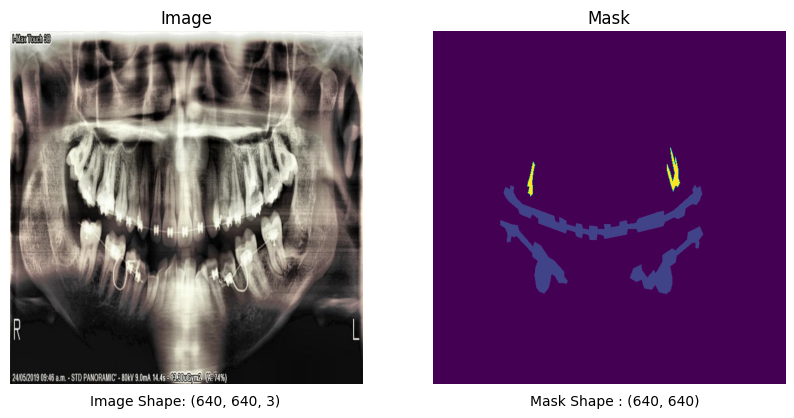

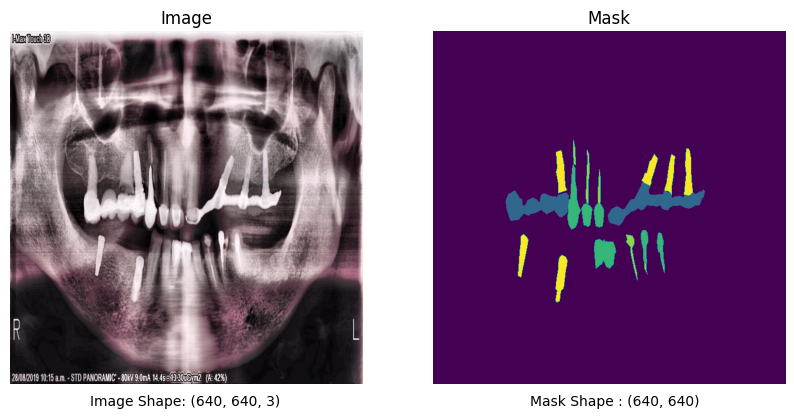

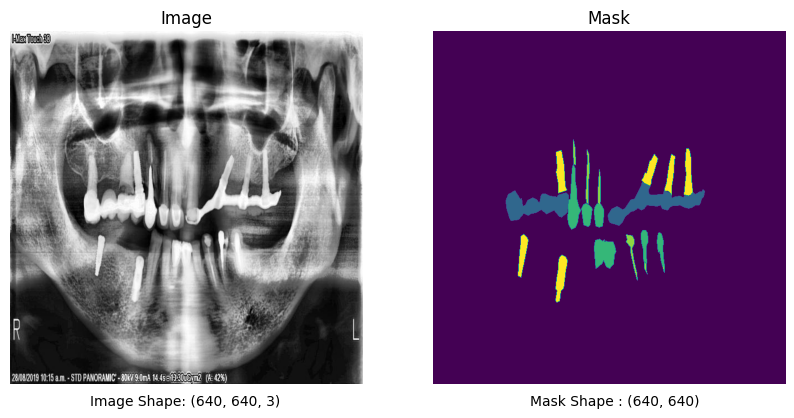

In [29]:


def load_patches_from_dataset(dataset_path, split, patch_size=256, step=256):

    # Set up array for image-mask pairs and transform to pytorch tensors
    dataset = []
    transform = transforms.ToTensor()

    # Get the dirs for images and masks
    split_dir = os.path.join(dataset_path, split)
    mask_dir = os.path.join(split_dir, "masks")

    # Skip if directory doesn't exist
    if not os.path.exists(split_dir) or not os.path.exists(mask_dir):
        print(f"No directory found for {split}")


    # Output image and corresponding masks for testing (number of images)
    num_images = 3


    # Process each image
    for filename in tqdm(sorted(os.listdir(split_dir))):
        
        img_path = os.path.join(split_dir, filename)
        mask_path = os.path.join(mask_dir, filename.replace(".jpg", "-segmentation-mask.png"))

        if filename.endswith(".json") or not os.path.isfile(img_path):
            continue  # Skip the annotations file and masks folder


        # Check the file dirs
        # print(mask_path, " ", img_path)


        # Load image and mask
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        mask  = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale


        # Convert to PyTorch tensors
        image_tensor = transform(image)
        mask_tensor = torch.tensor(mask, dtype=torch.long)  # Keep mask as integer labels

        # Append to dataset
        dataset.append((image_tensor, mask_tensor))



        if num_images > 0:
            # Create a subplot with 1 row and 2 columns
            plt.figure(figsize=(10, 5))

            # Show first image
            plt.subplot(1, 2, 1)
            plt.imshow(image)
            plt.axis('off')
            plt.title("Image")
            plt.figtext(0.30, 0.1,f"Image Shape: {image.shape}", ha='center')

            # Show second image
            plt.subplot(1, 2, 2)
            plt.imshow(mask)
            plt.axis('off')
            plt.title("Mask")
            plt.figtext(0.73, 0.1,f"Mask Shape : {mask.shape}", ha='center')

          
            num_images = num_images - 1



    return dataset


    #         # Patchify image & mask
    #         img_patches = patchify(image, (patch_size, patch_size, 3), step=step)  # (H, W, C)
    #         mask_patches = patchify(mask, (patch_size, patch_size), step=step)  # (H, W)

    #         # Store patches and metadata
    #         for i in range(img_patches.shape[0]):
    #             for j in range(img_patches.shape[1]):
    #                 single_patch_img = img_patches[i, j, 0]  # Remove extra dimension
    #                 single_patch_mask = mask_patches[i, j, 0]
                    
    #                 all_img_patches.append(single_patch_img)
    #                 all_mask_patches.append(single_patch_mask)
                    
    #                 # Store metadata
    #                 patch_metadata.append({
    #                     "split": split,
    #                     "original_filename": filename,
    #                     "patch_index": f"{i}_{j}",
    #                     "mask_max_value": single_patch_mask.max()  # Check if empty
    #                 })

    # # Convert to NumPy arrays
    # images = np.array(all_img_patches)
    # masks = np.array(all_mask_patches)

    # # Filter out empty masks
    # valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
    # filtered_images = images[valid_indices]
    # filtered_masks = masks[valid_indices]
    # filtered_metadata = [patch_metadata[i] for i in valid_indices]

    # print("Final Image Shape:", filtered_images.shape)  # (num_patches, 256, 256, 3)
    # print("Final Mask Shape:", filtered_masks.shape)  # (num_patches, 256, 256)

    # # Convert to Dataset
    # dataset_dict = {
    #     "image": [Image.fromarray(img) for img in filtered_images],
    #     "label": [Image.fromarray(mask) for mask in filtered_masks],
    # }
    # dataset = HFDataset.from_dict(dataset_dict)

    # # Convert metadata to DataFrame
    # df = pd.DataFrame(filtered_metadata)

    # return dataset, df





dataset_path = "Datasets/Dental project.v19i.coco-1"

dataset = load_patches_from_dataset(dataset_path, "test")

# Display metadata
# print(metadata_df.head())




In [ ]:

# Load masks into a DataFrame
def load_masks_to_dataframe(dataset_path, splits):
    mask_data = []  # Array of mask data

    for split in splits:

        # Get images from the current split
        split_path = os.path.join(dataset_path, split)
        mask_dir = os.path.join(split_path, "masks")

        # Check dir exists
        if not os.path.exists(mask_dir):
            print(f"No directory found: {mask_dir}")
            continue # Move onto next split


        # Loop through mask files and collect data
        for mask_filename in os.listdir(mask_dir):
            mask_path = os.path.join(mask_dir, mask_filename)

            

            # Get file name and full path)
            mask_data.append({
                "mask_filename": mask_filename,
                "mask_path": mask_path,
            })

    # Create a DataFrame from the collected mask data
    mask_df = pd.DataFrame(mask_data)
    
    return mask_df

# Root dataset folder
dataset_path = "Datasets/Dental project.v19i.coco-1"
splits = ["train"]

# Load masks into DataFrame
mask_df = load_masks_to_dataframe(dataset_path, splits)

# Display the DataFrame
print(mask_df)